In [ ]:
# Import all the necessary files!
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

train_dir = os.path.join('/content/gdrive/My Drive/dataset/mycopy/train_data')
val_dir = os.path.join('/content/gdrive/My Drive/dataset/mycopy/test_data')

train_fnames = os.listdir(train_dir)
validation_fnames = os.listdir(val_dir)
print(train_fnames,validation_fnames)

Mounted at /content/gdrive
['2', '3', '1'] ['2', '3', '1']


In [ ]:
for people in train_fnames:
  namess = os.path.join(train_dir+"/" + people)
  for items in os.listdir(namess):
    print(people + " "  + items)

2 17.jpg
2 1.jpg
2 2.jpg
2 4.jpg
2 9.jpg
2 19.jpg
2 20.jpg
2 14.jpg
2 13.jpg
2 3.jpg
2 12.jpg
2 8.jpg
2 15.jpg
2 5.jpg
2 11.jpg
2 10.jpg
2 18.jpg
2 7.jpg
2 6.jpg
2 16.jpg
3 2.jpg
3 11.jpg
3 8.jpg
3 10.jpg
3 5.jpg
3 7.jpg
3 13.jpg
3 14.jpg
3 15.jpg
3 17.jpg
3 18.jpg
3 20.jpg
3 16.jpg
3 19.jpg
3 12.jpg
3 9.jpg
3 3.jpg
3 1.jpg
3 6.jpg
3 4.jpg
1 7.jpg
1 11.jpg
1 14.jpg
1 12.jpg
1 6.jpg
1 5.jpg
1 4.jpg
1 3.jpg
1 2.jpg
1 1.jpg
1 8.jpg
1 9.jpg
1 13.jpg
1 19.jpg
1 15.jpg
1 16.jpg
1 18.jpg
1 10.jpg
1 17.jpg
1 20.jpg


In [ ]:
# Download the inception v3 weights
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2020-11-03 10:48:44--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.2.112, 142.250.73.240, 172.253.122.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.2.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  64.4MB/s    in 1.3s    

2020-11-03 10:48:45 (64.4 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [ ]:
# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Create an instance of the inception model from the local pre-trained weights
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'


In [ ]:

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)


pre_trained_model.load_weights(local_weights_file)
# Make all the layers in the pre-trained model non-trainable
for layer in pre_trained_model.layers:
  layer.trainable = False
  
# Print the model summary
# pre_trained_model.summary()


last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

# Expected Output:
# ('last layer output shape: ', (None, 7, 7, 768))


For now lets take mixed7 as output and check how good the embeddings are

> Indented block



last layer output shape:  (None, 7, 7, 768)


In [ ]:
# Define a Callback class that stops training once accuracy reaches 95.9%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>0.98):
      print("\nReached 99% accuracy so cancelling training!")
      self.model.stop_training = True

      

### Model Architecture

In [ ]:
# Hyper parameter
learnr = 0.00001  #learning rate
hu = 256    #no of hidden units in last layer

In [ ]:
from tensorflow.keras.optimizers import Adam

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with hu hidden units and ReLU activation
x = layers.Dense(hu, activation='relu')(x)
# Add a dropout rate of 0.2
# x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (3, activation='softmax')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = Adam(lr=learnr), 
              loss = 'categorical_crossentropy', 
              metrics = ['acc'])

# model.summary()

# Expected output will be large. Last few lines should be:

# mixed7 (Concatenate)            (None, 7, 7, 768)    0           activation_248[0][0]             
#                                                                  activation_251[0][0]             
#                                                                  activation_256[0][0]             
#                                                                  activation_257[0][0]             
# __________________________________________________________________________________________________
# flatten_4 (Flatten)             (None, 37632)        0           mixed7[0][0]                     
# __________________________________________________________________________________________________
# dense_8 (Dense)                 (None, 1024)         38536192    flatten_4[0][0]                  
# __________________________________________________________________________________________________
# dropout_4 (Dropout)             (None, 1024)         0           dense_8[0][0]                    
# __________________________________________________________________________________________________
# dense_9 (Dense)                 (None, 1)            1025        dropout_4[0][0]                  
# ==================================================================================================
# Total params: 47,512,481
# Trainable params: 38,537,217
# Non-trainable params: 8,975,264


NameError: ignored

In [ ]:
# # Get the Horse or Human dataset
# !wget --no-check-certificate https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip -O /tmp/horse-or-human.zip

# # Get the Horse or Human Validation dataset
# !wget --no-check-certificate https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip -O /tmp/validation-horse-or-human.zip 
  



# local_zip = '//tmp/horse-or-human.zip'
# zip_ref = zipfile.ZipFile(local_zip, 'r')
# zip_ref.extractall('/tmp/training')
# zip_ref.close()

# local_zip = '//tmp/validation-horse-or-human.zip'
# zip_ref = zipfile.ZipFile(local_zip, 'r')
# zip_ref.extractall('/tmp/validation')
# zip_ref.close()

In [ ]:
# train_horses_dir = os.path.join(train_dir, 'horses') # Directory with our training horse pictures
# train_humans_dir = os.path.join(train_dir, 'humans') # Directory with our training humans pictures
# validation_horses_dir = os.path.join(validation_dir, 'horses') # Directory with our validation horse pictures
# validation_humans_dir = os.path.join(validation_dir, 'humans')# Directory with our validation humanas pictures

# train_horses_fnames = os.listdir(train_horses_dir)
# train_humans_fnames = os.listdir(train_humans_dir)
# validation_horses_fnames = os.listdir(validation_horses_dir)
# validation_humans_fnames = os.listdir(validation_humans_dir)

# print(len(train_horses_fnames))
# print(len(train_humans_fnames))
# print(len(validation_horses_fnames))
# print(len(validation_humans_fnames))

# # Expected Output:
# # 500
# # 527
# # 128
# # 128

Mounted at /content/gdrive


In [ ]:

# Define our example directories and files
train_dir = '/content/gdrive/My Drive/dataset/mycopy/train_data'
validation_dir = '/content/gdrive/My Drive/dataset/mycopy/test_data'

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 1,
                                                    class_mode = 'categorical', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 1,
                                                          class_mode  = 'categorical', 
                                                          target_size = (150, 150))

Found 60 images belonging to 3 classes.
Found 60 images belonging to 3 classes.


In [ ]:
# Run this and see how many epochs it should take before the callback
# fires, and stops training at 99.9% accuracy
# (It should take less than 100 epochs)
callbacks = myCallback()
history = model.fit_generator(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 18,
            epochs = 80,
            validation_steps = 6,
            verbose = 2,
            callbacks=[callbacks])

Epoch 1/80
18/18 - 1s - loss: 0.7928 - acc: 0.7778 - val_loss: 0.8632 - val_acc: 0.5000
Epoch 2/80
18/18 - 0s - loss: 0.6612 - acc: 0.7778 - val_loss: 0.6950 - val_acc: 0.5000
Epoch 3/80
18/18 - 1s - loss: 0.5229 - acc: 0.8333 - val_loss: 0.6440 - val_acc: 0.8333
Epoch 4/80
18/18 - 0s - loss: 0.4402 - acc: 0.7778 - val_loss: 0.4582 - val_acc: 1.0000
Epoch 5/80
18/18 - 1s - loss: 0.3699 - acc: 0.9444 - val_loss: 0.5507 - val_acc: 0.8333
Epoch 6/80
18/18 - 1s - loss: 0.2969 - acc: 0.9444 - val_loss: 0.2745 - val_acc: 1.0000
Epoch 7/80
18/18 - 0s - loss: 0.3710 - acc: 0.8889 - val_loss: 0.3680 - val_acc: 1.0000
Epoch 8/80
18/18 - 1s - loss: 0.2841 - acc: 0.9444 - val_loss: 0.6107 - val_acc: 0.8333
Epoch 9/80
18/18 - 0s - loss: 0.2359 - acc: 0.9444 - val_loss: 0.5935 - val_acc: 0.6667
Epoch 10/80
18/18 - 0s - loss: 0.3845 - acc: 0.8333 - val_loss: 0.6547 - val_acc: 0.6667
Epoch 11/80
18/18 - 1s - loss: 0.3087 - acc: 0.8889 - val_loss: 0.2267 - val_acc: 1.0000
Epoch 12/80
18/18 - 0s - loss:

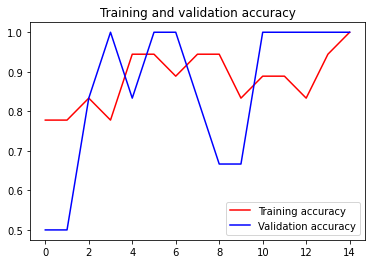

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()